In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import RidgeCV, LinearRegression, LassoCV
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
pd.options.display.max_columns = 14
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Any results you write to the current directory are saved as output.

In [2]:
pd.options.display.max_rows = 400
train.tail( )

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [3]:
test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [4]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Numerical Features

In [7]:
numeric_features = list(train.select_dtypes(exclude=['O','category']).columns)
numeric_features_num = len(numeric_features)
print("No of numeric Features: ",numeric_features_num,"\nNumeric Features:", numeric_features)

No of numeric Features:  7 
Numeric Features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


## Categorical Features

In [8]:
category_features= list(train.select_dtypes(include = ['O','category']).columns)
category_features_num = len(category_features)
print("No of categorical features:",category_features_num,
      "\nCategory Features:",category_features)

No of categorical features: 5 
Category Features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [9]:
train1 = train.copy()
test1 = test.copy()
for col in category_features:
    train1[col] = train1[col].astype('category')
    test1[col] = test1[col].astype('category')
#     print(col, test_c[col].cat.categories)
print(train1['Ticket'].cat.categories)

Index(['110152', '110413', '110465', '110564', '110813', '111240', '111320',
       '111361', '111369', '111426',
       ...
       'STON/O2. 3101290', 'SW/PP 751', 'W./C. 14258', 'W./C. 14263',
       'W./C. 6607', 'W./C. 6608', 'W./C. 6609', 'W.E.P. 5734', 'W/C 14208',
       'WE/P 5735'],
      dtype='object', length=681)


## Feature Selection and transformation

### 1.Sex

In [10]:
print(sum(train1['Sex'].isnull()))
print(sum(test1['Sex'].isnull()))

0
0


In [11]:
print(train1['Sex'].dtypes)
print(test1['Sex'].dtypes)

category
category


In [12]:
sex_train = pd.DataFrame({'Number':train1['Sex'].value_counts()})
sex_train['Percentage'] = train1['Sex'].value_counts()/train1.shape[0]
sex_train['Survived'] = train1['Survived'].groupby(train['Sex']).mean()
display(sex_train)
sex_test = pd.DataFrame({'Number':test1['Sex'].value_counts()})
sex_test['Percentage'] = test1['Sex'].value_counts()/test1.shape[0]
display(sex_test)

,Number,Percentage,Survived
male,577,0.647587,0.188908
female,314,0.352413,0.742038


,Number,Percentage
male,266,0.636364
female,152,0.363636


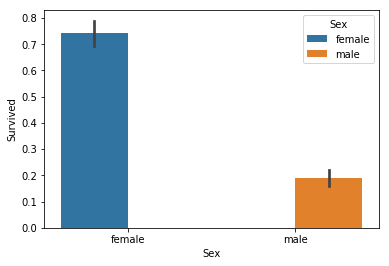

In [13]:
sns.barplot(x='Sex', y= 'Survived', hue = 'Sex', data = train1)

### 2. Cabin

In [14]:
print(sum(train1['Cabin'].isnull()))
print(sum(test1['Cabin'].isnull()))

687
327


In [15]:
print(train1['Cabin'].dtypes)
print(test1['Cabin'].dtypes)

category
category


In [16]:
train1['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [17]:
train1['Cabin'].cat.add_categories('None', inplace = True)
train1['Cabin'].fillna('None', inplace = True)
train1['Cabin'] = train1['Cabin'].apply(lambda x:x[0])
print(train1['Cabin'].dtypes)

object


In [18]:
display(pd.DataFrame({'Survived':train1['Cabin'][train1['Survived']==1].value_counts()})
        .sort_values(by = 'Survived'))

,Survived
G,2
A,7
F,8
E,24
D,25
B,35
C,35
N,206


In [19]:
test1['Cabin'].cat.add_categories('None', inplace = True)
test1['Cabin'].fillna('None', inplace = True)
test1['Cabin'] = test1['Cabin'].apply(lambda x:x[0])
print(test1['Cabin'].dtypes)

object


In [20]:
cabin_train = pd.DataFrame({'Number':train1['Cabin'].value_counts(),'Percentage':train1['Cabin'].value_counts()
                            /train1.shape[0]})
# cabin_train['Survived'] = (train1['Cabin'][train1['Survived']==1]).value_counts()
cabin_train['Survived'] = train1['Survived'].groupby(train1['Cabin']).mean()
cabin_train['Survive_F'] = train1['Cabin'][train1['Sex'] == 'female'][train1['Survived']==1].value_counts()
cabin_train['Survive_M'] = train1['Cabin'][train1['Sex'] == 'male'][train1['Survived']==1].value_counts()
cabin_test = pd.DataFrame({'Number':test1['Cabin'].value_counts(),'Percentage':test1['Cabin'].value_counts()/
                          test1.shape[0]})
display(cabin_train,cabin_test)

,Number,Percentage,Survived,Survive_F,Survive_M
N,687,0.771044,0.299854,142.0,64.0
C,59,0.066218,0.593220,24.0,11.0
B,47,0.052750,0.744681,27.0,8.0
D,33,0.037037,0.757576,18.0,7.0
E,32,0.035915,0.750000,14.0,10.0
A,15,0.016835,0.466667,1.0,6.0
F,13,0.014590,0.615385,5.0,3.0
G,4,0.004489,0.500000,2.0,NaN
T,1,0.001122,0.000000,NaN,NaN


,Number,Percentage
N,327,0.782297
C,35,0.083732
B,18,0.043062
D,13,0.031100
E,9,0.021531
F,8,0.019139
A,7,0.016746
G,1,0.002392


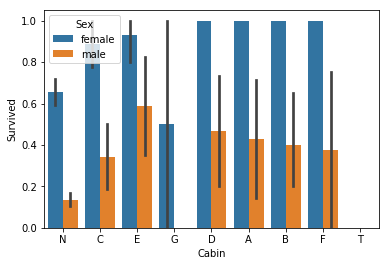

In [21]:
sns.barplot(x = 'Cabin', y = 'Survived',hue='Sex', data = train1) 

In [22]:
print(test1['Sex'][test1['Cabin']=='N'].value_counts())
print(train1['Sex'][train1['Cabin']=='N'].value_counts())

male      219
female    108
Name: Sex, dtype: int64
male      470
female    217
Name: Sex, dtype: int64


### 3.Embarked

In [23]:
print(sum(train1['Embarked'].isnull()))
print(sum(test1['Embarked'].isnull()))

2
0


In [24]:
train1.drop(train1.index[train1['Embarked'].isnull()], axis = 0, inplace = True)
train1['Embarked'].isnull().any()

False

In [25]:
print(train1['Embarked'].dtypes)
print(test1['Embarked'].dtypes)

category
category


In [26]:
print(train1['Embarked'].value_counts())
print(test['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    270
C    102
Q     46
Name: Embarked, dtype: int64


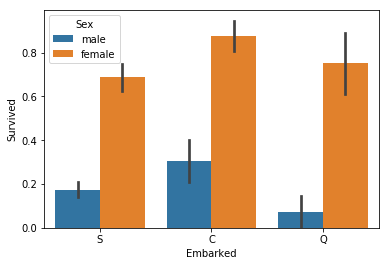

In [27]:
sns.barplot(x = "Embarked", y = "Survived", hue = "Sex",data = train)

### 4.Ticket

In [28]:
print(sum(train1['Ticket'].isnull()))
print(sum(test1['Ticket'].isnull()))

0
0


In [29]:
print(train1['Ticket'].dtypes)
print(test1['Ticket'].dtypes)

category
category


In [30]:
temp = train1['Ticket'].apply(lambda x: x.split(' ')[0])
display(temp)

0             A/5
1              PC
2        STON/O2.
3          113803
4          373450
5          330877
6           17463
7          349909
8          347742
9          237736
10             PP
11         113783
12           A/5.
13         347082
14         350406
15         248706
16         382652
17         244373
18         345763
19           2649
20         239865
21         248698
22         330923
23         113788
24         349909
25         347077
26           2631
27          19950
28         330959
29         349216
30             PC
31             PC
32         335677
33           C.A.
34             PC
35         113789
36           2677
37          A./5.
38         345764
39           2651
40           7546
41          11668
42         349253
43       SC/Paris
44         330958
45      S.C./A.4.
46         370371
47          14311
48           2662
49         349237
50        3101295
51           A/4.
52             PC
53           2926
54         113509
55        

### 5.Name

In [31]:
print(sum(train1['Name'].isnull()))
print(sum(test1['Name'].isnull()))

0
0


In [32]:
print(train1['Name'].dtypes, test1['Name'].dtypes)

category category


In [33]:
train1['Title'] =(train1['Name'].apply(lambda x:x.split(',')[1]).apply(lambda x:x.split()[0]))
test1['Title'] = test1['Name'].apply(lambda x:x.split(',')[1]).apply(lambda x:x.split()[0])
display(pd.DataFrame(test1['Title'].value_counts()))

,Title
Mr.,240
Miss.,78
Mrs.,72
Master.,21
Rev.,2
Col.,2
Ms.,1
Dona.,1
Dr.,1


In [34]:
display(pd.DataFrame({'Number':train1['Title'].value_counts(),
                    'Survived':train1['Survived'].groupby(train1['Title']).mean()}))

,Number,Survived
Capt.,1,0.000000
Col.,2,0.500000
Don.,1,0.000000
Dr.,7,0.428571
Jonkheer.,1,0.000000
Lady.,1,1.000000
Major.,2,0.500000
Master.,40,0.575000
Miss.,181,0.696133
Mlle.,2,1.000000


In [35]:
train1['Title'] = train1['Title'].replace(
               ['the','Sir.','Rev.','Ms.', 'Major.','Capt.','Col.','Don.','Dr.','Jonkheer.','Lady.','Mme.',
               'Mlle.'],'Rare')

test1['Title'] = test1['Title'].replace(['the','Sir.','Rev.','Ms.', 'Major.','Capt.','Col.',
                                       'Don.','Dr.','Jonkheer.','Lady.','Mme.','Mlle.','Dona.'],'Rare')
display(pd.DataFrame({'Number':train1['Title'].value_counts(),
                    'Survived':train1['Survived'].groupby(train1['Title']).mean()}))
display(pd.DataFrame({'Number':test1['Title'].value_counts()}))

,Number,Survived
Master.,40,0.575000
Miss.,181,0.696133
Mr.,517,0.156673
Mrs.,124,0.790323
Rare,27,0.444444


,Number
Mr.,240
Miss.,78
Mrs.,72
Master.,21
Rare,7


In [36]:
train1.drop(['Name'], axis = 1, inplace = True)
test1.drop(['Name'], axis = 1, inplace = True)

### 6. Pclass

In [37]:
print(sum(train1['Pclass'].isnull()))
print(sum(test1['Pclass'].isnull()))

0
0


In [38]:
print(train1['Pclass'].dtypes, test1['Pclass'].dtypes)

int64 int64


In [39]:
pclass_train = pd.DataFrame(train1['Pclass'].value_counts())
pclass_test = pd.DataFrame(test1['Pclass'].value_counts())
display(pclass_train)
display(pclass_test)

,Pclass
3,491
1,214
2,184


,Pclass
3,218
1,107
2,93


In [40]:
pd.crosstab(train['Pclass'], columns=train['Sex'])

Sex,female,male
Pclass,,
1,94,122
2,76,108
3,144,347


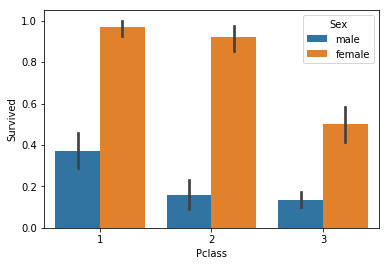

In [41]:
sns.barplot(x= "Pclass", y = "Survived", hue = "Sex", data = train)

### 7.SibSp

In [42]:
print(sum(train1['SibSp'].isnull()))
print(sum(test1['SibSp'].isnull()))

0
0


In [43]:
sibsp_train = pd.DataFrame({"Number": train1['SibSp'].value_counts()})
sibsp_test = pd.DataFrame({"Number": test1['SibSp'].value_counts()})
display(sibsp_train)
display(sibsp_test)

,Number
0,606
1,209
2,28
4,18
3,16
8,7
5,5


,Number
0,283
1,110
2,14
4,4
3,4
8,2
5,1


In [44]:
display(pd.crosstab(train1['SibSp'], columns=train1['Sex']))
display(pd.crosstab(test1['SibSp'], columns=test1['Sex']))

Sex,female,male
SibSp,,
0,172,434
1,106,103
2,13,15
3,11,5
4,6,12
5,1,4
8,3,4


Sex,female,male
SibSp,,
0,88,195
1,54,56
2,6,8
3,1,3
4,1,3
5,1,0
8,1,1


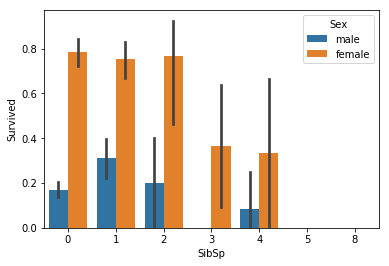

In [45]:
sns.barplot(x = 'SibSp', y = "Survived", hue='Sex', data = train)

### 8.Parch

In [46]:
print(sum(train1['Parch'].isnull()))
print(sum(test1['Parch'].isnull()))

0
0


In [47]:
parch_train = pd.DataFrame({"Number": train1['Parch'].value_counts()
                           ,'Survived':train1['Survived'].groupby(train1['Parch']).mean()})
parch_test = pd.DataFrame({"Number": test1['Parch'].value_counts()})
display(parch_train)
display(parch_test)

,Number,Survived
0,676,0.341716
1,118,0.550847
2,80,0.500000
3,5,0.600000
4,4,0.000000
5,5,0.200000
6,1,0.000000


,Number
0,324
1,52
2,33
3,3
9,2
4,2
6,1
5,1


In [48]:
display(pd.crosstab(train1['Parch'], columns=train1['Sex']))
display(pd.crosstab(test1['Parch'], columns=test1['Sex']))

Sex,female,male
Parch,,
0,192,484
1,60,58
2,49,31
3,4,1
4,2,2
5,4,1
6,1,0


Sex,female,male
Parch,,
0,99,225
1,28,24
2,20,13
3,2,1
4,2,0
5,0,1
6,0,1
9,1,1


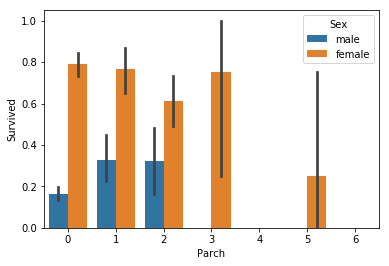

In [49]:
sns.barplot(x = "Parch", y = "Survived", hue = 'Sex', data = train)

### 9.Age

In [50]:
print(sum(train1['Age'].isnull()))
print(sum(test1['Age'].isnull()))

177
86


In [51]:
print(train1['Age'].dtypes)
print(test1['Age'].dtypes)

float64
float64


In [52]:
display(train1['Survived'].groupby(pd.qcut(train1['Age'],6)).mean())

Age
(0.419, 18.0]    0.503597
(18.0, 23.0]     0.308411
(23.0, 28.0]     0.387931
(28.0, 34.0]     0.413793
(34.0, 44.0]     0.416667
(44.0, 80.0]     0.368421
Name: Survived, dtype: float64

In [53]:
age_train = pd.DataFrame({'Number': train1['Age'].value_counts()})
age_train['Age'] = age_train.index
age_train.sort_values(by = 'Number', inplace = True)
age_train.set_index('Age', inplace = True)
display(age_train)

,Number
Age,
0.42,1
20.50,1
24.50,1
0.67,1
14.50,1
0.92,1
74.00,1
34.50,1
23.50,1


In [54]:
train1.fillna({'Age': train1['Age'].median()}, inplace = True)
test1.fillna({'Age':test1['Age'].median()}, inplace = True)
print("Done")

Done


In [55]:
def SimplifyAge(df):
    print(df['Age'].min(), df['Age'].max())
    bins = (0, 7, 13, 18, 25, 55, 120)
    labels_name = ["Baby", "child", "adult", "young", "old1", "old2"]
    categories = pd.cut(df['Age'], bins, labels = labels_name)
    df['Age'] = categories
    return df
train1 = SimplifyAge(train1)
test1 = SimplifyAge(test1)

0.42 80.0
0.17 76.0


### 10.Fare

In [56]:
train['Survived'].groupby(pd.qcut(train['Fare'], 7)).mean()

Fare
(-0.001, 7.75]       0.207143
(7.75, 8.05]         0.200000
(8.05, 12.475]       0.316327
(12.475, 19.258]     0.406250
(19.258, 27.9]       0.445312
(27.9, 56.929]       0.456000
(56.929, 512.329]    0.685039
Name: Survived, dtype: float64

In [57]:
print(sum(train1['Fare'].isnull()))
print(sum(test1['Fare'].isnull()))

0
1


In [58]:
test1.fillna({'Fare':test1['Fare'].median()}, inplace = True)
print("")

In [59]:
print(train1['Fare'].value_counts())

8.0500      43
13.0000     42
7.8958      38
7.7500      34
26.0000     31
10.5000     24
7.9250      18
7.7750      16
7.2292      15
26.5500     15
0.0000      15
8.6625      13
7.2500      13
7.8542      13
7.2250      12
9.5000       9
16.1000      9
24.1500      8
15.5000      8
31.2750      7
14.5000      7
56.4958      7
52.0000      7
69.5500      7
14.4542      7
7.0500       7
7.7958       6
46.9000      6
21.0000      6
27.9000      6
30.0000      6
39.6875      6
26.2500      6
30.5000      5
73.5000      5
53.1000      5
15.2458      5
27.7208      5
29.1250      5
34.3750      4
120.0000     4
79.2000      4
12.4750      4
7.7333       4
7.5500       4
110.8833     4
7.1250       4
11.5000      4
21.0750      4
39.0000      4
151.5500     4
90.0000      4
27.7500      4
13.5000      4
23.0000      4
7.6500       4
15.8500      4
7.8792       4
25.4667      4
263.0000     4
35.5000      4
19.2583      4
31.3875      4
227.5250     4
20.5250      3
512.3292     3
29.7000   

In [60]:
def SimplifyFare(df):
    print(df['Fare'].min(), df['Fare'].max())
    bins = (-1.00 , 8,12,20, 55, 600.00)
    labels_name = ["General", "Sleeper","SecondAC","FirstAC",'Top']
    categories = pd.cut(df['Fare'], bins, labels = labels_name)
    df['Fare'] = categories
    df['Fare'] = df['Fare'].astype('category')
# #     df.replace({'Fare':{"General":1.0, "Sleeper":4.0, "SecondAC":9.0, "FirstAC": 16.0}}, inplace = True)
#     df['Fare'] = df['Fare'].astype(np.number)
    return df
train1 = SimplifyFare(train1)
test1 = SimplifyFare(test1)

0.0 512.3292
0.0 512.3292


<hr>

In [61]:
print(train1.isnull().any())
print(test1.isnull().any())

PassengerId    False
Survived       False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
Title          False
dtype: bool
PassengerId    False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
Title          False
dtype: bool


1. We need to get dummy Variables for "Pclass", "Sex", "Embarked".
1. We need to transform features "Cabin", "Name", "Ticket".


### Feature Transformation


In [62]:
ids = test1["PassengerId"]

train1.drop(["Ticket","PassengerId"], axis = 1,inplace = True)
test1.drop(["Ticket","PassengerId"], axis = 1, inplace = True)

In [63]:
print(train1.isnull().any().any())
train1.head()

False


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,young,1,0,General,N,S,Mr.
1,1,1,female,old1,1,0,Top,C,C,Mrs.
2,1,3,female,old1,0,0,General,N,S,Miss.
3,1,1,female,old1,1,0,FirstAC,C,S,Mrs.
4,0,3,male,old1,0,0,Sleeper,N,S,Mr.


In [64]:
print(test1.isnull().any().any())
test1.head()

False


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,3,male,old1,0,0,General,N,Q,Mr.
1,3,female,old1,1,0,General,N,S,Mrs.
2,2,male,old2,0,0,Sleeper,N,Q,Mr.
3,3,male,old1,0,0,Sleeper,N,S,Mr.
4,3,female,young,1,1,SecondAC,N,S,Mrs.


In [65]:
print(train1.select_dtypes(exclude = ['object','category']).columns)
print(test1.select_dtypes(exclude = ['object','category']).columns)

Index(['Survived', 'Pclass', 'SibSp', 'Parch'], dtype='object')
Index(['Pclass', 'SibSp', 'Parch'], dtype='object')


No of numeric Features:  6 
Numeric Features: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


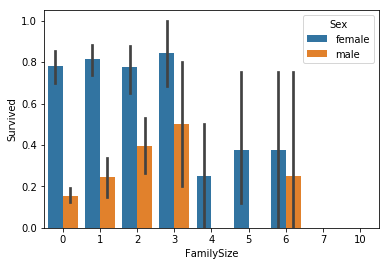

In [66]:
numeric_features = list(test.select_dtypes(exclude=['O','category']).columns)
numeric_features_num = len(numeric_features)
print("No of numeric Features: ",numeric_features_num,"\nNumeric Features:", numeric_features)
train1['FamilySize'] = train1['Parch'] + train1['SibSp']
test1['FamilySize'] = test1['Parch'] + test1['SibSp']
# train.replace({"Pclass":{1:3,3:1}}, inplace = True)
# test.replace({"Pclass":{1:3,3:1}}, inplace = True)

# train1['FamilySize'] = train1['FamilySize'].astype('category')
# test1['FamilySize'] = test1['FamilySize'].astype('category')
# train1.replace({"Sex":{"male":1, "female":2}}, inplace = True)
# test1.replace({"Sex":{"male":1, "female":2}}, inplace = True)
# train1["Sex"] = train1['Sex'].astype(np.number)
# test1["Sex"] = test1['Sex'].astype(np.number)
train1.drop(['Parch', 'SibSp'], axis = 1, inplace = True)
test1.drop(['Parch', 'SibSp'], axis = 1, inplace = True)
sns.barplot(x = "FamilySize", y ="Survived", hue= 'Sex', data = train1)

# display(train.head())
def SimplifyFamilySize(df):
    bins = (-1, 0, 1, 2, 3, 10)
    labels_name = ["VerySmall", "Small", "Medium", "Average", "Large"]
    categories = pd.cut(df['FamilySize'], bins, labels = labels_name)
    df['FamilySize'] = categories
    return df

train1 = SimplifyFamilySize(train1)
test1 = SimplifyFamilySize(test1)
# display(train.head())

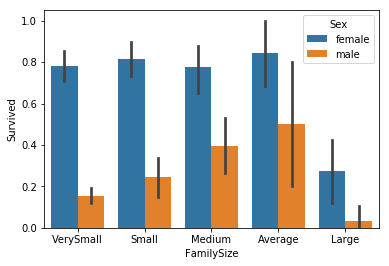

In [67]:
sns.barplot(x = "FamilySize", y ="Survived", hue= 'Sex',data = train1)

<hr>

In [68]:
# print(Test.shape)
X = train1.drop(["Survived"], axis =1)
y = train1["Survived"]
Test = test1
print(Test.shape)
print(X.shape[0])
data_combined = pd.concat([X, Test], ignore_index= True)
display(data_combined.head())
# data_combined['family_size_male'] = 'None'
# data_combined['family_size_male'][data_combined['Sex']=='male'] = data_combined['FamilySize'][data_combined['Sex']=='male']
# for i in range(data_combined.shape[0]):
#     if(data_combined['Sex'].iloc[i] == 'male'):
#         data_combined['family_size_male'].iloc[i] = data_combined['FamilySize'].iloc[i]

# data_combined.replace({'family_size_male':{'None':0, 'Large':1, 'VerySmall':2, 
#                                            'Small':3,'Medium':4,'Average':5}}, inplace = True)
# data_combined['family_size_male'] = data_combined['family_size_male'].astype(np.number)
display(data_combined.head())
data_combined = pd.get_dummies(data_combined)
pd.options.display.max_columns = 50
display(data_combined.head())

(418, 8)
889


,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,male,young,General,N,S,Mr.,Small
1,1,female,old1,Top,C,C,Mrs.,Small
2,3,female,old1,General,N,S,Miss.,VerySmall
3,1,female,old1,FirstAC,C,S,Mrs.,Small
4,3,male,old1,Sleeper,N,S,Mr.,VerySmall


,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,male,young,General,N,S,Mr.,Small
1,1,female,old1,Top,C,C,Mrs.,Small
2,3,female,old1,General,N,S,Miss.,VerySmall
3,1,female,old1,FirstAC,C,S,Mrs.,Small
4,3,male,old1,Sleeper,N,S,Mr.,VerySmall


,Pclass,Sex_female,Sex_male,Age_Baby,Age_child,Age_adult,Age_young,Age_old1,Age_old2,Fare_General,Fare_Sleeper,Fare_SecondAC,Fare_FirstAC,Fare_Top,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,FamilySize_VerySmall,FamilySize_Small,FamilySize_Medium,FamilySize_Average,FamilySize_Large
0,3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0
1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
2,3,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0
3,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
4,3,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0


In [69]:
print(data_combined.shape)
# data_combined["Sex_sq"] = data_combined["Sex"]**2
# data_combined["Pclass_inv"] = data_combined["Pclass"]**2
# data_combined.drop(["Pclass"], axis = 1, inplace = True)
data_combined.drop(['Cabin_T'], axis = 1, inplace = True)
display(data_combined.ix[0:2,:])
X = data_combined.ix[0:X.shape[0]-1,:]
Test = data_combined.ix[X.shape[0]:, :]
print(X.shape)
print(Test.shape)

(1307, 36)


,Pclass,Sex_female,Sex_male,Age_Baby,Age_child,Age_adult,Age_young,Age_old1,Age_old2,Fare_General,Fare_Sleeper,Fare_SecondAC,Fare_FirstAC,Fare_Top,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Embarked_C,Embarked_Q,Embarked_S,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,FamilySize_VerySmall,FamilySize_Small,FamilySize_Medium,FamilySize_Average,FamilySize_Large
0,3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0
1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
2,3,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0


(889, 35)
(418, 35)


In [70]:
from sklearn.model_selection import train_test_split
X_train , X_test, y_train , y_test = train_test_split(X,y , test_size = 0.2, random_state = 0)

In [71]:
print(X_train.shape)
print(Test.shape)

(711, 35)
(418, 35)


In [72]:
from sklearn.linear_model import LogisticRegression

regr = LogisticRegression()
regr.fit(X_train, y_train)
score1 = regr.score(X_train , y_train)
score2 = regr.score(X_test, y_test)
print(score1, score2)

0.853727144866 0.730337078652


In [92]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

def run_kfold(clf):
    kf = KFold(314, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        print(X_train.shape)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_test, clf.predict(X_test))
        print(cm)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(svc)

(282, 35)
[[14  2]
 [ 5 11]]
Fold 1 accuracy: 0.78125
(282, 35)
[[17  4]
 [ 2  9]]
Fold 2 accuracy: 0.8125
(282, 35)
[[21  0]
 [ 4  7]]
Fold 3 accuracy: 0.875
(282, 35)
[[17  6]
 [ 2  7]]
Fold 4 accuracy: 0.75
(283, 35)
[[22  2]
 [ 1  6]]
Fold 5 accuracy: 0.9032258064516129
(283, 35)
[[21  1]
 [ 1  8]]
Fold 6 accuracy: 0.9354838709677419
(283, 35)
[[15  2]
 [ 4 10]]
Fold 7 accuracy: 0.8064516129032258
(283, 35)
[[19  4]
 [ 4  4]]
Fold 8 accuracy: 0.7419354838709677
(283, 35)
[[13  3]
 [ 4 11]]
Fold 9 accuracy: 0.7741935483870968
(283, 35)
[[11  4]
 [ 5 11]]
Fold 10 accuracy: 0.7096774193548387
Mean Accuracy: 0.8089717741935484


In [75]:
regr.fit(X, y)
Prediction_regr = regr.predict(Test)
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': Prediction_regr })
output.to_csv('predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [76]:
#Support Vector Machine
from sklearn.svm import SVC

for x in [10]:
    svc = SVC(kernel='linear', C= 10)
    svc.fit(X_train , y_train)
    score1 = svc.score(X_train, y_train)
    score2 = svc.score(X_test, y_test)
    print(score1, score2)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, svc.predict(X_test))
print(cm)

0.845288326301 0.758426966292
[[88 17]
 [26 47]]


In [77]:
Prediction_svc = svc.predict(Test)
output_svc = pd.DataFrame({ 'PassengerId' : ids, 'Survived': Prediction_svc })
output_svc.to_csv('predictions_svm.csv', index = False)
sum(output_svc['Survived'] == output_svc['Survived'])

418

##### Decision Tree

In [93]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
for n in [2]:
    rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=500,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
    rf.fit(X_train , y_train)
    score1 = rf.score(X_train, y_train)
    score2 = rf.score(X_test, y_test)
    print(score1, score2)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, rf.predict(X_test))
print(cm)

0.881856540084 0.76404494382
0.881856540084 0.76404494382
0.881856540084 0.76404494382
0.881856540084 0.76404494382
0.881856540084 0.76404494382
0.881856540084 0.76404494382
[[91 14]
 [28 45]]


In [79]:
parameters = [{'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]}]
grid_search = GridSearchCV(estimator = clf, param_grid = parameters, scoring = 'accuracy', cv =10)
grid_search.fit(X.values, y.values)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_accuracy)
print(best_parameters)

0.829021372328
{'max_depth': 3}


In [96]:
rf.fit(X.values , y.values)
Prediction_rf = clf.predict(Test)
output_clf = pd.DataFrame({'PassengerId': ids , 'Survived': Prediction_clf})
output_clf.to_csv('prediction_decision.csv', index = False)
sum(output_clf['Survived'] != output_svc['Survived'])

9

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
xg = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.1, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10)
xg.fit(X_train , y_train)
score1 = xg.score(X_train, y_train)
score2 = xg.score(X_test, y_test)
print(score1, score2)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, xg.predict(X_test))
print(cm)

0.907172995781 0.780898876404
[[93 12]
 [27 46]]


In [83]:
xg.fit(X, y)
Prediction_xg = xg.predict(Test)
output_clf = pd.DataFrame({'PassengerId': ids , 'Survived': Prediction_xg})
output_clf.to_csv('prediction_xg.csv', index = False)
sum(output_clf['Survived'] != output_svc['Survived'])

42

In [84]:
display(Prediction_xg ==1
       )

array([False, False, False, False,  True, False,  True, False,  True,
       False, False, False,  True, False,  True,  True, False, False,
       False,  True, False,  True,  True, False,  True, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False,  True, False, False, False,  True,  True,
       False, False, False,  True, False, False, False,  True,  True,
       False, False, False, False, False,  True, False, False, False,
        True,  True,  True,  True, False, False,  True,  True, False,
       False,  True,  True, False, False,  True, False,  True,  True,
       False, False, False, False, False,  True,  True, False,  True,
        True, False,  True, False, False, False,  True, False,  True,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
        True, False,  True,  True, False,  True, False, False, False,
       False,  True,

In [94]:
Prediction = (Prediction_svc + Prediction_clf + Prediction_xg)//2
# temp = Prediction==2
# Prediction[Prediction!=2] = Prediction[Prediction!=2]//2 
# Prediction[temp] = (Prediction_xg[temp] + Prediction_svc[temp])//2

In [97]:
print(sum(Prediction == Prediction_svc))
print(sum(Prediction == Prediction_clf))
print(sum(Prediction == Prediction_xg))
print(Prediction.shape)

411
416
383
(418,)


In [91]:

output_ens = pd.DataFrame({'PassengerId': ids , 'Survived': Prediction})
output_ens.to_csv('prediction_ens.csv', index = False)